# Import of python library


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster
from PIL import Image
import math
from sklearn.preprocessing import LabelEncoder
from sklearn import tree

from IPython.display import display
import random


## 1. Creation of the color bank


In [3]:

# charging the color bank from the CSV file
names=["Color name", "RGB", "HEX"]
with open("./colorPalette.tsv", "r") as file:
    lines = file.read().splitlines()
    lines = lines[1:]
    for i,line in enumerate(lines):
        line = line.split("\t")
        r = int (line[1].split(",")[0].split("(")[1])
        g = int (line[1].split(",")[1])
        b = int (line[1].split(",")[2].split(")")[0])
       
        line[1] = (r, g, b)
        lines[i] = line
colorBank = pd.DataFrame(lines, columns=names)   

In [4]:
# Normalize to the nearrest color from our color bank to limit the nuances of color (almost infinit with our kmeans method)
def distanceCalcul(color1, color2):
    return math.sqrt( (color2[0]-color1[0])**2 + (color2[1]-color1[1])**2 + (color2[2]-color1[2])**2)

def colorNormalisation(paletteColor: pd.DataFrame , color : tuple) -> str:
    distanceMin = math.inf
    
    for index in paletteColor.index:
        distance = distanceCalcul(paletteColor["RGB"][index], color)
        if (distance < distanceMin):
            distanceMin = distance
            colordistancemin = paletteColor["Color name"][index]
    
    return colordistancemin

# print(colorNormalisation(colorPalette, (44, 143,163)))


# 2. Preparation of the dataset Images


## Exctraction of the images files


In [ ]:
rootDirectory = "./flowers"
# for all images the path will be rootDirectory / plantName /file  example ./flowers/jpeg-192x192/train/alpine sea holly/11331.jpeg


subdir = []
informationsOnImages = []
for repo, subrepos, files in os.walk(rootDirectory):
    subdir.append(subrepos)
    # filelist.append(files)

print(subdir[0])
for dir in subdir[0]:
  
    # for all images the path will be rootDirectory / plantName /file  || example ./flowers/jpeg-192x192/train/alpine sea holly/11331.jpeg

    filelist = []
    namelist = []
    for repo, subrepos, files in os.walk("{}/{}/train".format(rootDirectory, dir)):
        namelist.append(subrepos)
        filelist.append(files)

    namelist = namelist[0]
    filelist = filelist[1:]

    
    

    for name, files  in zip(namelist, filelist):
            for i, image in enumerate( files) :
                # limite at 10 images by type for the need of the test (4160 images out of 12000)
                if i < 10:                                                              
                    informationsOnImages.append({"size": int(dir[9:]), "name":name, "file":image, "color1":"", "color2": "", "color3": ""})
                else:
                    break
            
datasetImages = pd.DataFrame(informationsOnImages)

# datasetImages


## Extraction of principal colors


In [ ]:

nb_cluster = 5
for index, row in datasetImages.iterrows():

    imgfile = Image.open(
        "{root}/jpeg-{size}x{size}/train/{type}/{file}".format(
            root = rootDirectory,
            size = row["size"], 
            type = row["name"], 
            file = row["file"]
            )
        )
    
    # extraction of 5 main color
    numarray = np.array(imgfile.getdata(), np.float64)
    clusters = sklearn.cluster.MiniBatchKMeans(n_clusters= nb_cluster)
    clusters.fit(numarray)

    # ordering the colors
    npbins = np.arange(0, nb_cluster + 1)
    histogram = np.histogram(clusters.labels_, bins=npbins)
    palette = clusters.cluster_centers_
    indicesMax = histogram[0].argsort()

    # add the 3 main colors normalized into the datasetImage
    datasetImages.loc[index, "color1"] = colorNormalisation(colorBank, palette[indicesMax[-1]])
    datasetImages.loc[index, "color2"] = colorNormalisation(colorBank, palette[indicesMax[-2]])
    datasetImages.loc[index, "color3"] = colorNormalisation(colorBank, palette[indicesMax[-3]])   
    imgfile.close() 

       
# datasetImages.head(15)

## Save the dataset into json file to avoid making the Kmeans each time


In [ ]:
# save the dataframe to json File to avoid having to execute MinibatchKmeans
datasetImages.to_json(path_or_buf="./data.json", orient="index")

# 3. Creation of the classes


## To load the Dataset from json file


In [5]:
# Extract data from json file to load the dataframe with colors
datasetImages = pd.read_json(path_or_buf="./data.json", orient="index")
print(datasetImages)

      size              name        file            color1            color2  \
0      192  alpine sea holly  11331.jpeg        Dark Green         Dark Gray   
1      192  alpine sea holly  11562.jpeg  Light Slate Gray           DimGray   
2      192  alpine sea holly  12036.jpeg   Dark Slate Gray  Dark Olive Green   
3      192  alpine sea holly  12186.jpeg              Gray        Olive Drab   
4      192  alpine sea holly  12341.jpeg             Black   Dark Slate Gray   
...    ...               ...         ...               ...               ...   
4155   512       yellow iris  10404.jpeg             Black  Dark Olive Green   
4156   512       yellow iris  10412.jpeg             Black   Dark Slate Gray   
4157   512       yellow iris  10417.jpeg        Olive Drab      Yellow Green   
4158   512       yellow iris  10536.jpeg   Dark Slate Gray         Goldenrod   
4159   512       yellow iris  10590.jpeg  Dark Olive Green  Dark Olive Green   

                color3  
0           Ol

# Creation of the users class


In [78]:
class User:
    
    def __init__(self, age = None, sex = None, preferredColor=None):

        # "equivalent of java surcharge function"
        # 2 ways to create users 
        # normal user we ask the user his values as input 
        # fake user of testing process we can pass values
        self.setAge(age)
        self.setSex(sex)
        self.setPreferredColor(preferredColor)

        self.__likedImages = pd.DataFrame()
        self.__unlikedImages = pd.DataFrame()
        self.__decisionTree = tree.DecisionTreeClassifier()
        self.__modelAccuracy = {"tp": [], "fp":[], "fn" : []}

    def setAge(self, age=None) -> None:
        if age == None:
            ok = False
            while not ok:
                age = input("What is your age: ")
                if age.isnumeric():
                    age = int(age)
                    ok = True
        
        self.__age = age
    def setSex(self, sex=None) -> None:
        if sex == None:
            sex = ""
            while sex not in ("M", "F"):
                sex = input("Please select sex (M/F):").upper()
            
        self.__sex = sex


    def setPreferredColor(self, preferredColor=None) -> None:
        # user can select his preferred color in our colorBank(137 colors)
        if preferredColor == None:
            print(colorBank["Color name"])
            preferredColor = ""
            while preferredColor not in map(str.lower, colorBank["Color name"].values):
                preferredColor = input("Please select your preferred color in the list above").lower()
        
        self.__preferredColor = preferredColor

    def addImagesHistory(self, images:pd.DataFrame, notation:list) -> None:
        images = images.reset_index(drop=True)
        
        for index, image in images.iterrows():
            if notation[index] == "y":
                self.__likedImages = self.__likedImages.append(image)
            else:
                self.__unlikedImages = self.__unlikedImages.append(image)
        self.__likedImages["like"] = 1
        self.__unlikedImages["like"] = 0
            

    def getAge(self) -> int:
        return self.__age
    
    def getSex(self) -> str:
        return self.__sex

    def getPreferredColor(self)-> str:
        return self.__preferredColor

    def getLikedImages(self) -> pd.DataFrame:
        return self.__likedImages.drop(["like"], axis=1).copy()

    def getUnlikedImages(self) -> pd.DataFrame:
        return self.__unlikedImages.drop(["like"], axis=1).copy()    

   

    def trainDecisionTree(self) -> None:
        # creation of the trainset  with the historique of all images that has been view by user
        trainImages = self.__likedImages.append(self.__unlikedImages, ignore_index=True)

        # shuffle the trainset
        trainImages = trainImages.iloc[np.random.permutation(len (trainImages))]

        # get the result from the trainset (1 or 0 for lliked or disliked)
        result = trainImages["like"]

        # drop the columns that doesn't count in the fitting
        trainImages = trainImages.drop(["file", "like"], axis=1)
        trainImages = trainImages.reset_index(drop=True)

        # fitting
        self.__decisionTree = self.__decisionTree.fit(trainImages, result)

    def printDecisionTree(self) -> None:

        fig = plt.figure(figsize=(25,20))
        _ = tree.plot_tree(self.__decisionTree, 
                   feature_names=["size", "name", "color1", "color2", "color3"],  
                   class_names=["unliked", "liked"],
                   filled=True)



    def predictLikedImages(self, images) -> list:
        # make a prediction on like or not of the images presented
        return self.__decisionTree.predict(images)

    def setModelAccuracy(self, tp, fp, fn) -> None:
        self.__modelAccuracy["tp"].append(tp)
        self.__modelAccuracy["fp"].append(fp)
        self.__modelAccuracy["fn"].append(fn)
    
    def getMetrics(self) -> dict :
        return self.__modelAccuracy
        
    def getScore(self) -> dict:
        tp = self.__modelAccuracy["tp"][-1]
        fp = self.__modelAccuracy["fp"][-1]
        fn = self.__modelAccuracy["fn"][-1]
        p = tp / (tp + fp)
        r = tp / (tp + fn)
        return {"precision": p, "recall" : r, "f1": 2 * (p * r)/(p + r)}


# Creation of the recommendation System


In [113]:
class recommendationSystem:
    def __init__(self, Images: pd.DataFrame):
        self.listUser = pd.DataFrame()
        self.datasetImages = Images
        self.LabelEncoder = self.createLabelEncoder()
        self.datasetImagesEncoded = self.fitEncodeLabels(self.datasetImages.copy())
        self.fitEncodeResults(["n", "y"])

    ## functions to code and decode the pd.DataFrame 
    def createLabelEncoder(self) -> None:
        leName = LabelEncoder()
        leTaille = LabelEncoder()
        leColor1 = LabelEncoder()
        leColor2= LabelEncoder()
        leColor3 = LabelEncoder()
        leResult = LabelEncoder()
        return {
            "name" : leName, 
            "size" : leTaille, 
            "color1" : leColor1, 
            "color2" : leColor2, 
            "color3" : leColor3, 
            "result" : leResult
            }


    def fitEncodeLabels(self, sets:pd.DataFrame) -> pd.DataFrame:
        sets["name"] = self.LabelEncoder["name"].fit_transform(sets["name"])
        sets["size"] = self.LabelEncoder["size"].fit_transform(sets["size"])
        sets["color1"] = self.LabelEncoder["color1"].fit_transform(sets["color1"])
        sets["color2"] = self.LabelEncoder["color2"].fit_transform(sets["color2"])
        sets["color3"] = self.LabelEncoder["color3"].fit_transform(sets["color3"])

        return sets

    def fitEncodeResults(self, result: list) -> None:
        self.LabelEncoder["result"].fit_transform(result)

    
    def encodeLabels(self, sets:pd.DataFrame) -> pd.DataFrame:
        sets["name"] = self.LabelEncoder["name"].transform(sets["name"])
        sets["size"] = self.LabelEncoder["size"].transform(sets["size"])
        sets["color1"] = self.LabelEncoder["color1"].transform(sets["color1"])
        sets["color2"] = self.LabelEncoder["color2"].transform(sets["color2"])
        sets["color3"] = self.LabelEncoder["color3"].transform(sets["color3"])

        return sets

    def decodeLabels(self,sets:pd.DataFrame ) -> pd.DataFrame:
        sets["name"] = self.LabelEncoder["name"].inverse_transform(sets["name"].astype(int))
        sets["size"] = self.LabelEncoder["size"].inverse_transform(sets["size"].astype(int))
        sets["color1"] = self.LabelEncoder["color1"].inverse_transform(sets["color1"].astype(int))
        sets["color2"] = self.LabelEncoder["color2"].inverse_transform(sets["color2"].astype(int))
        sets["color3"] = self.LabelEncoder["color3"].inverse_transform(sets["color3"].astype(int))

        return sets

    def encodeResults(self, result: list) -> list:
        return self.LabelEncoder["result"].transform(result)

    def decodeResults(self, result:list) -> list:
        return self.LabelEncoder["result"].inverse_transform(result)

    def addUserToList(self, newUser:User):
        # for add an user to our data base
        self.listUser = self.listUser.append(pd.DataFrame([
                {
                    "user": newUser,
                    "age":newUser.getAge(), 
                    "sex": newUser.getSex(), 
                    "color": newUser.getPreferredColor()
                }
            ]), ignore_index=True)

    def createSpecialUser(self, numberOfSimulatedImages = 30)-> User:
        #creation of the user
        age = random.randint(10,90),
        sex = random.choice(["M", "F"])
        preferredColor = random.choice(colorBank["Color name"])
        newUser = User(age=age, sex=sex, preferredColor=preferredColor)
        self.addUserToList(newUser=newUser)
        
        # simulate the choice of numberOfSimulatedImages images
        imageslist = self.datasetImagesEncoded.sample(numberOfSimulatedImages)
        result = random.choices(["y", "n"] , k=numberOfSimulatedImages)
        
        # add alls theses images to the history of the user
        newUser.addImagesHistory(imageslist, result)
        # train the Decision tree 
        newUser.trainDecisionTree()
        return newUser
   
    def createUser(self) -> User:
        # create the user parsing parameter for the false user or the test
        newUser = User()
        # ask the user a first round of images
        self.askFirstImages(newUser)
        # add the user to our database of users
        self.addUserToList(newUser=newUser)
        return newUser


    def getImages(self, imageslist) -> list:
        
        rootDirectory = "./flowers"
        result = []
        for index, image in imageslist.iterrows():
            # opening each images to propose to the user
            imgfile = Image.open(
                "{root}/jpeg-{size}x{size}/train/{type}/{file}".format(
                    root = rootDirectory,
                    size = image["size"], 
                    type = image["name"], 
                    file = image["file"]
                    )
                )
            
            display(imgfile)
            valid = False
            # get the user response on the image (force the response format) 
            while not valid:
                    userLike = input("Do you like this image? (y/n)").lower()
                    if (userLike == "y" or userLike == "n"):
                        valid = True
                        result.append(userLike)
         
            imgfile.close()
               
        return result

    def askFirstImages(self, client:User) -> None:
        firstImages = pd.DataFrame()
        age = client.getAge()
        sex = client.getSex()

        # selecting a sample of images to present to the user for the first time 
        try:
            # can add the preferred color 
            # could be better not to selected directly in people with the same age and sex but to do
            # a collaborative filtering, but real data are needed for this king of ML random data will give 
            # absurd values
            similarUsers = self.listUser[( abs(self.listUser["age"]-age) < 5 ) & (self.listUser["sex"] == sex)]
            for user in similarUsers:
                firstImages = firstImages.append(user.getLikedImages())

            if len(firstImages["file"]) > 15:
                firstImages = firstImages.sample(15)

        except:
            firstImages = self.datasetImagesEncoded.sample(15)

        # decoding the table to can be able to get the path
        imageslist = self.decodeLabels(firstImages)
        
         # calling the display function to get user preferences
        result = self.getImages(imageslist=imageslist)

        # recode the images to give to the fitting function
        imageslist = self.encodeLabels(imageslist)
        # add alls theses images to the history of the user
        client.addImagesHistory(firstImages, result)
        # train the Decision tree 
        client.trainDecisionTree()
        
        # init the accuracy
        client.setModelAccuracy(tp = 0, fp = 0, fn = 0 )

    

    def askNewImages(self, client: User, numberOfImagesMax = 10) -> None:
        imagesPredictedLike = pd.DataFrame()
        imagesPredictedDislike = pd.DataFrame()
        predictedset = []
        
        # selecting new sample of images based on user preferences
        for i in range(100):
            # try 100 times to get some images that are predicted to be liked if not working
            # means that we don't have enough data so we get default images 
            newImageset = self.datasetImagesEncoded.sample(numberOfImagesMax, ignore_index=True)
            
            # submitting the sample to the DecisionTree to know of the user would like those images
            predictedset = client.predictLikedImages(newImageset.drop(["file"], axis=1))

            # if we found images that will fit with the user preferences we quit the loop
            if any(predictedset):
                break
        
        # decoding the dataset of images to get the real path
        newImageset = self.decodeLabels(newImageset)
    
        if any(predictedset): 
            # separation of the images labeled as likeable and dislikeable 
            for index, image in newImageset.iterrows():
                if predictedset[index] :
                    imagesPredictedLike = imagesPredictedLike.append(image)
                else:
                    imagesPredictedDislike = imagesPredictedDislike.append(image)
            
            # adding some images labeled as unliked to keep bias 
            imagesPredictedLike =   imagesPredictedLike if imagesPredictedDislike.empty else imagesPredictedLike.append(imagesPredictedDislike.sample(frac=0.1))  

        else: # getting default images 
            imagesPredictedLike = imagesPredictedLike.append(newImageset)


        predictedset = client.predictLikedImages(self.encodeLabels(imagesPredictedLike.drop(["file"], axis=1)))
        print(predictedset)
        

        # parsing the size to int cause the decode methode transform our 224 to 224.0 which not exist in path
        imagesPredictedLike["size"] = imagesPredictedLike["size"].astype(int)
        
        # limit the sampling a 10 to avoid presenting the user to much images at the same time
        if imagesPredictedLike["name"].size > 10:
            imagesPredictedLike = imagesPredictedLike.sample(10)
        
        
        # calling the display function to get user preferences
        result = self.getImages(imageslist=imagesPredictedLike)

         # recode the images to give to the fitting function
        imageslist = self.encodeLabels(imagesPredictedLike)
        # add alls theses images to the history of the user
        client.addImagesHistory(imageslist, result)
        # train the Decision tree 
        client.trainDecisionTree()
        
        # calcul of the metrics
        tp, fp, fn = self.evaluate(result, self.decodeResults(predictedset), client.getMetrics())
        client.setModelAccuracy(tp = tp, fp = fp, fn = fn )


    def evaluate(self, result, prediction, oldMetrics) -> int:
        # evaluate method can be perform uniquely on real users
        # Didn't make sens to evaluate score on random data
        tp = oldMetrics["tp"][-1]
        fp = oldMetrics["fp"][-1]
        fn = oldMetrics["fn"][-1]

        for res, pred in zip (result, prediction):
            if res == "y" and pred == "y": # true positive
                tp+=1
            elif res == "y" and pred == "n": # false negative
                fn +=1
            elif res == "n" and pred == "y": # false positive
                fp += 1

        return tp, fp, fn

         
        
    def saveUsers(self) -> None : 
        save = self.listUser.copy()
        save.insert(0, "userId" ,save.index)
        save = save.reset_index()

        linkDict =  {"idUser": [], "idImage": [], "like": []}
        for indexUser,  user in save.iterrows():
            for indexImages, image in (self.decodeLabels( user["user"].getLikedImages())).iterrows():

                imageID = self.datasetImages[
                   (self.datasetImages["size"] == image["size"])  &
                   (self.datasetImages["name"] == image["name"])  &
                   (self.datasetImages["file"] == image["file"])  
                   ].index[0]

                linkDict["idUser"].append( user["userId"])
                linkDict["idImage"].append( imageID)
                linkDict["like"].append(1)


            for indexImages, image in (self.decodeLabels( user["user"].getUnlikedImages())).iterrows():

                imageID = self.datasetImages[
                   (self.datasetImages["size"] == image["size"])  &
                   (self.datasetImages["name"] == image["name"])  &
                   (self.datasetImages["file"] == image["file"])  
                   ].index[0]

                linkDict["idUser"].append( user["userId"])
                linkDict["idImage"].append( imageID)
                linkDict["like"].append(0)
        
        save = save.drop(["user", "index"], axis=1)
        save["age"] = save["age"].map(lambda age: age[0])
        linkTable = pd.DataFrame(linkDict)

        # save users and Table link to json
        save.to_json(path_or_buf="./users.json", orient="index")
        linkTable.to_json(path_or_buf="./linkTable.json", orient="index")
        
    def loadUsers(self) -> None:
        # Extract data from json file to load the dataframe with colors
        users = pd.read_json(path_or_buf="./users.json", orient="index")
        link = pd.read_json(path_or_buf="./linkTable.json", orient="index")
        pd.options.mode.chained_assignment = None
        for indexUser, user in users.iterrows():
            # extraction of the images likes by user
            imagesLikes = self.datasetImages.iloc[
                link["idImage"][
                    (link['idUser'] == user["userId"]) &
                    (link['like'] == 1)
                ]
            ]

            imagesDislikes = self.datasetImages.iloc[
                link["idImage"][
                    (link['idUser'] == user["userId"]) &
                    (link['like'] == 0)
                ]
            ]

           

            #creation of a new User and add it to the model Dataframe
            age = user["age"]
            sex = user["sex"]
            preferredColor = user["color"]

            newUser = User(age=age, sex=sex, preferredColor=preferredColor)

            newUser.addImagesHistory(images=self.encodeLabels(imagesLikes), notation=["y"]*len(imagesLikes))
            newUser.addImagesHistory(images=self.encodeLabels(imagesDislikes), notation=["n"]*len(imagesDislikes))
            
            self.addUserToList(newUser=newUser)
            newUser.trainDecisionTree()

            
            
            

        

# 4. Use of the system

## creation of an instance 

In [ ]:
example = recommendationSystem(Images=datasetImages.copy())

## Creation of an user 

In [ ]:
newuser = example.createUser()

# method for a user to ask for new images

In [ ]:
example.askNewImages(newuser, numberOfImagesMax=10)

In [ ]:
newuser.getMetrics()

## method to save and load users

In [ ]:
example.saveUsers()

# 5. Simulation

## Fake user to fill de data base

In [114]:
flowers = recommendationSystem(Images = datasetImages.copy())

## creation of fake users
nbFakeUser = 20
listFUsers = []
for i in range(nbFakeUser):
    listFUsers.append(flowers.createSpecialUser(numberOfSimulatedImages=30))

# print(flowers.listUser)

In [116]:

flowers.loadUsers()


In [117]:
# ploting of the Decision Tree Classifier
flowers.listUser


,user,age,sex,color
0,<__main__.User object at 0x00000211004F8DC0>,"(65,)",M,Dark Olive Green
1,<__main__.User object at 0x00000211004F83D0>,"(68,)",M,Misty Rose
2,<__main__.User object at 0x00000211009A1550>,"(25,)",F,Yellow
3,<__main__.User object at 0x00000211003E3130>,"(25,)",F,Hot Pink
4,<__main__.User object at 0x000002110028E250>,"(35,)",M,Light Blue
5,<__main__.User object at 0x00000211003E3520>,"(62,)",F,Ghost White
6,<__main__.User object at 0x000002110026DD60>,"(61,)",F,Misty Rose
7,<__main__.User object at 0x00000211003E3E50>,"(53,)",M,Aquamarine
8,<__main__.User object at 0x00000211003E38E0>,"(72,)",M,Medium Orchid
9,<__main__.User object at 0x000002110026D8B0>,"(84,)",M,Green Yellow


## Real user

In [ ]:
realUser = flowers.createUser()

In [ ]:
flowers.askNewImages(realUser)

In [ ]:
realUser.printDecisionTree()

In [136]:
realUser.getScore()

{'precision': 0.5, 'recall': 0.5, 'f1': 0.5}

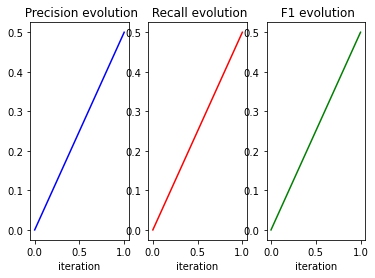

In [145]:
# ploting the evolution of the decisions tree score for a user
metrics = realUser.getMetrics()
precision = [0]
recall = [0]
f1 = [0]
# extraction of all the scores
for i in range (1, len(metrics["tp"])):
    tp = metrics['tp'][i]
    fp = metrics['fp'][i]
    fn = metrics['fn'][i]
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    f = 2 * (p * r)/(p + r)

    precision.append(p)
    recall.append(r)
    f1.append(f)



# ploting of scores

# precision
plt.subplot(1, 3, 1)
plt.plot(precision, color="blue")
plt.xlabel("iteration")
plt.title(" Precision evolution")




# recall
plt.subplot(1, 3, 2)
plt.plot(precision, color="red")
plt.xlabel("iteration")
plt.title(" Recall evolution")


# f1
plt.subplot(1, 3, 3)
plt.plot(precision, color="green")
plt.xlabel("iteration")
plt.title(" F1 evolution")

plt.show()


In [ ]:
flowers.saveData()

# 6. Data Visualisation


In [ ]:
workingset = flowers.listUser.copy()
workingset["age"] = list(map(lambda age: age[0], workingset["age"] ))

## Average age 

In [ ]:

averageAge = workingset["age"].mean()
print(averageAge)


averageAgeBySex = workingset.groupby("sex")["age"].mean()

print(averageAgeBySex)


## count number of user by age and sex

In [ ]:
usersBySexAge = workingset.groupby(["sex", "age"]).count().unstack('sex')["user"]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(40, 25))
males = usersBySexAge["M"].dropna()
males.plot(x = "age", y="M", kind="bar", title="Males", ax = axes[0])
females = usersBySexAge["F"].dropna()
females.plot(x = "age", y="F", kind="bar", title="Female", ax = axes[1])
plt.show()

## Preferred Colors


In [ ]:
userPreferredColors = workingset['color'].value_counts()
bar = userPreferredColors.iloc[:10].plot(kind = "bar")
plt.show()

## Most Represented Color in our dataset Images


In [ ]:
fig = plt.figure(figsize=(30, 20)) 
maincolor = pd.DataFrame( datasetImages["color1"].value_counts()).reset_index()
secondcolor = pd.DataFrame( datasetImages["color2"].value_counts()).reset_index()
thirdcolor = pd.DataFrame( datasetImages["color3"].value_counts()).reset_index()

colors = [maincolor, secondcolor, thirdcolor]
for i, colo in enumerate(colors):
    ax1 = plt.subplot(3, 1, i+1)
    colo.loc[ colo["color" +str(i+1)] <100, 'index' ] = "other"
    colo = colo.groupby('index')["color" +str(i+1)].sum().reset_index()

    plt.pie(x=colo["color" +str(i+1)], labels= colo["index"], autopct="%.1f%%")
    plt.legend(loc="best", bbox_to_anchor=(2.5,0), title="Colors")


# 7. Creation of UI

In [ ]:
# Import required libraries
import tkinter as tk
from PIL import ImageTk, Image
import tkinter.messagebox as tkMessageBox

fenetre = 1
# Create an instance of tkinter window
win = tk.Tk()

if fenetre == 1:
    #Create a canvas object
    canvas= Canvas(win, width= 1000, height= 750, bg="SpringGreen2")

    #Add a text in Canvas
    canvas.create_text(300, 50, text="HELLO", fill="black", font=('Helvetica 15 bold'))
    canvas.pack()

# Define the geometry of the window
win.geometry("700x500")



In [ ]:
# fenetre 2

if fenetre == 2:
    frame = tk.Frame(win, width=600, height=400)
    frame.pack()
    frame.place(anchor='center', relx=0.5, rely=0.5)

    # Create an object of tkinter ImageTk
    img = ImageTk.PhotoImage(Image.open("./flowers/jpeg-192x192/train/alpine sea holly/2250.jpeg"))


    BLike = tk.Button(win, text = "like", command = lambda: hello("y"))
    BDislike = tk.Button(win, text = "dislike", command = lambda: hello("n"))

    # Create a Label Widget to display the text or Image
    label = tk.Label(frame, image = img)
    label.pack()
    BDislike.place(x=100, y=400)
    BLike.place(x=600, y=400)

def hello(val:str):
    if val == "y":
        tkMessageBox.showinfo("Result", "You like")
        
    else:
        tkMessageBox.showinfo("Result", "no")






win.mainloop()

In [ ]:
import tkinter as tk
from PIL import ImageTk, Image
import time

#Create an object of tkinter ImageTk

class GUI:
    def __init__(self, master,path):
        self.i = 0
        self.master = master
        self.master.title("A simple GUI")
        self.result = []

        self.label = tk.Label(master, text="Do you like it ?")
        self.label.grid(row= 1, column=2,columnspan=2)
  
        self.path = path
        self.img = ImageTk.PhotoImage(Image.open(path[self.i]))
        label = tk.Label(root, image = self.img)
        label.grid(row= 2, column=2,columnspan=2,rowspan=2,sticky='news')
        
        self.greet_button = tk.Button(master, text="DISLIKE", command=self.dislike)
        self.greet_button.grid(row= 4, column=2,columnspan=1)

        self.close_button = tk.Button(master, text="LIKE", command=self.like)
        self.close_button.grid(row= 4, column=3,columnspan=1)

    def like (self):
        self.result.append("y")
        self.rotation()

    def dislike (self):
        self.result.append("n")        
        self.rotation()
        
    
    def rotation(self): #path en arg je pense (pas ds une liste)

        self.i +=1
        if self.i == len(self.path)-1:
            root.destroy()
        self.img = ImageTk.PhotoImage(Image.open(self.path[self.i]))
        label = tk.Label(root, image = self.img)
        label.grid(row= 2, column=2,columnspan=2,rowspan=2,sticky='news')
        


path = [
    "./flowers/jpeg-192x192/train/alpine sea holly/2250.jpeg",
    "./flowers/jpeg-192x192/train/alpine sea holly/2261.jpeg",
    "./flowers/jpeg-192x192/train/alpine sea holly/2281.jpeg",
    "./flowers/jpeg-192x192/train/alpine sea holly/2740.jpeg",
    "./flowers/jpeg-192x192/train/alpine sea holly/4064.jpeg",
    "./flowers/jpeg-192x192/train/alpine sea holly/6683.jpeg",
    "./flowers/jpeg-192x192/train/alpine sea holly/6879.jpeg"]


root = tk.Tk()

#Define the geometry of the window
root.geometry("600x600")

my_gui = GUI(root,path)
root.mainloop()
print( "saltu")


